In [39]:
import os
import torch
import pandas as pd
from skimage import io, transform
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

seed = 69

torch.manual_seed(seed)
np.random.seed(seed)

In [97]:
test=pd.read_csv("mnist/train.csv")

In [102]:
class MnistDataset(Dataset):
    def __init__(self, csv_file, transform=None, train=True):
        '''
        Args:
            csv_file (string)
            transform (callable, optional)
        '''
        
        self.mnist = pd.read_csv(csv_file)
        self.train = train
        self.transform = transform
        
    def __len__(self):
        return len(self.mnist)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img = self.mnist.iloc[idx].values[1:]
        img = np.reshape(img, (28,28))
        img = img / 255
        img = Image.fromarray(img)          

        if self.transform:
            img = self.transform(img)
        
        if self.train:
            label = self.mnist.iloc[idx][0]
            label = np.array(label)

            sample = {"label": torch.from_numpy(label), "image":img}
                
        else:
            sample = {"image": torch.from_numpy(img)}
            

            
        return sample

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        return {'image': torch.from_numpy(image),
                'label': torch.from_numpy(label)}

In [109]:
training_split = 0.8
batch_size = 32

mnist_train_dataset = MnistDataset("mnist/train.csv", transform=transforms.Compose([
                                                                                    transforms.RandomRotation(2.8),
                                                                                    transforms.ToTensor(),
                                                                                    transforms.Normalize((0.130,), (0.3081)),
                                                                                     ]))
mnist_test_dataset = MnistDataset("mnist/test.csv", train=False, transform=transforms.Compose([
                                                                                    transforms.ToTensor(),
                                                                                     ]))

train_length = int(training_split * len(mnist_train_dataset))
validation_length = len(mnist_train_dataset) - train_length

train_dataset, validation_dataset = torch.utils.data.random_split(mnist_train_dataset, (train_length, validation_length))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test_dataset, batch_size=1, shuffle=False)

<Figure size 432x288 with 0 Axes>

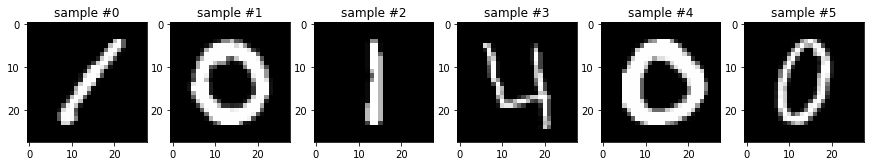

In [110]:
imgs_ = 6
fig = plt.figure()
plt.figure(figsize=(15,imgs_))
for i in range(imgs_):
    ax = plt.subplot(1, imgs_, i+1)
    ax.set_title('sample #{}'.format(i))
    plt.imshow(np.reshape(mnist_train_dataset[i]["image"], (28,28)), cmap='gray')
    
plt.show()

In [ ]:
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(4 * 7 * 7, 10)
        )


In [116]:
learning_rate = 0.005
momentum = 0.5

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = CNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [117]:
def train(epoch, loader, log_interval=500):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, data in enumerate(train_loader):
        
        variables = data["image"].float().to(device)
        target = data["label"].to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(variables)
        # Calculate loss
        loss = criterion(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

def validate(loss, accuracy_list, loader):
    model.eval()
    val_loss, correct = 0, 0
    
    for data in loader:
        variables = data["image"].float().to(device)
        target = data["label"].to(device)
        
        
        output = model(variables)
        val_loss += criterion(output, target).data.item()
        
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(loader)
    loss.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(loader.dataset)
    accuracy_list.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset), accuracy))

In [ ]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'batch_size': args.batch_size}
    if use_cuda:
        kwargs.update({'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True},
                     )

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")

In [119]:
epochs = 1

loss_, acc_ = [], []
for epoch in range(1, epochs + 1):
    train(epoch, train_loader)
    validate(loss_, acc_ , validation_loader)

Train Epoch: 1 [0/33600 (0%)]	Loss: 0.168269
Train Epoch: 1 [16000/33600 (48%)]	Loss: 0.418278
Train Epoch: 1 [32000/33600 (95%)]	Loss: 0.204197

Validation set: Average loss: 0.1607, Accuracy: 8012/8400 (95%)



In [ ]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)